코드출처 : https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb

#### Reqirements

- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
# Install required libs1

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
# !pip install -U albumentations --user 
# !pip install -U --pre segmentation-models --user

## Loading dataset
---

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.plot import show

import math
from tqdm.notebook import tqdm

In [2]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')

            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")

init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [3]:
DATA_DIR = os.path.join(os.getenv('HOME'), 'workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings')

TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'training/raw')
TRAIN_LABEL_DIR = os.path.join(DATA_DIR, 'training/label')
VAL_IMG_DIR = os.path.join(DATA_DIR, 'validation/raw')
VAL_LABEL_DIR = os.path.join(DATA_DIR, 'validation/label')

In [4]:
SPLIT_IMG_DIR = os.path.join(os.getenv('HOME'), 'workspace/Hackerton/workspace/Model/split')

TRAIN_SPLIT_IMG_DIR = os.path.join(SPLIT_IMG_DIR, 'train/image')
TRAIN_SPLIT_LABEL_DIR = os.path.join(SPLIT_IMG_DIR, 'train/label')
VAL_SPLIT_IMG_DIR = os.path.join(SPLIT_IMG_DIR, 'val/image')
VAL_SPLIT_LABEL_DIR = os.path.join(SPLIT_IMG_DIR, 'val/label')

In [5]:
TRAIN_TARGET_LIST = os.path.join(os.getenv('HOME'), 'workspace/Hackerton/RSI_OP_NIA_AIHUB/B_train_list.txt')
VAL_TARGET_LIST = os.path.join(os.getenv('HOME'), 'workspace/Hackerton/RSI_OP_NIA_AIHUB/B_val_list.txt')

## Preprocessing
---

### 1. Read TIF and Split

#### A. sample

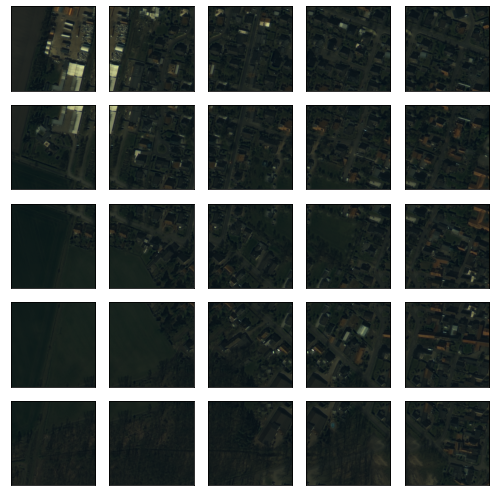

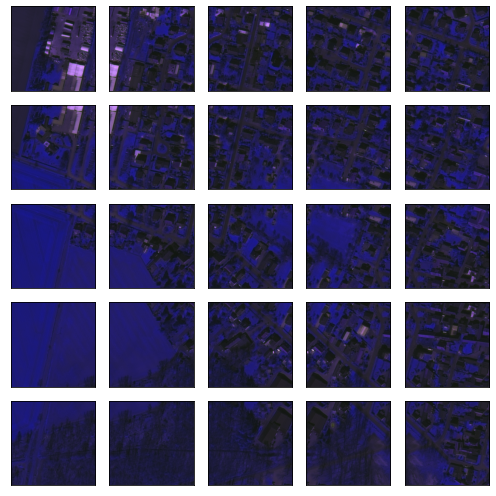

In [106]:
SAMPLE = os.path.join(TRAIN_IMG_DIR, 'BLD03118_PS4_K3A_NIA0376.tif')
STRIDE_SZ = 192
INPUT_SIZE = 256

with rasterio.open(SAMPLE, 'r') as image:
    bands = np.array([image.read(i) for i in image.indexes])
    image_norm = (bands - bands.min()) / (bands.max() - bands.min())
    
    pts = []
    for slice_pos in range(25):
        pos_i = int(math.floor(slice_pos / 5.0))
        pos_j = int(slice_pos % 5)
        x0 = STRIDE_SZ * pos_i
        y0 = STRIDE_SZ * pos_j
        pts.append((x0, x0+INPUT_SIZE, y0, y0+INPUT_SIZE))
    
    res = []
    for i in range(0, 2) :
        img = image_norm[i:i+3]
        sub_imgs = [img[:, x0:x1, y0:y1] for x0, x1, y0, y1 in pts]
        
        plt.figure(figsize=(7, 7))
        for i, sub_img in enumerate(sub_imgs):
            sub_img = np.swapaxes(sub_img, 0, 2)
            sub_img = np.swapaxes(sub_img, 0, 1)
            res.append(sub_img)
            
            plt.subplot(5, 5, i+1)
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            plt.imshow(sub_img)
            
        plt.tight_layout()
        plt.show()

#### B. 함수 정의

In [6]:
def get_slice_pos(split_cnt, STRIDE_SIZE, INPUT_SIZE):
    pts = []
    for slice_pos in range(split_cnt):
        pos_i = int(math.floor(slice_pos / 5.0))
        pos_j = int(slice_pos % 5)
        x = STRIDE_SIZE * pos_i
        y = STRIDE_SIZE * pos_j
        pts.append((x, x+INPUT_SIZE, y, y+INPUT_SIZE))
    return pts

In [7]:
def split_tif(img_path, pts):
    with rasterio.open(img_path, 'r') as f:
        bands = np.array([f.read(i) for i in image.indexes])
        image_norm = (bands - bands.min()) / (bands.max() - bands.min())
                
        res = []
        for i in range(0, 2) :
            img = image_norm[i:i+3]
            sub_imgs = [img[:, x0:x1, y0:y1] for x0, x1, y0, y1 in pts]

            for i, sub_img in enumerate(sub_imgs):
                sub_img = np.swapaxes(sub_img, 0, 2)
                sub_img = np.swapaxes(sub_img, 0, 1)
                res.append(sub_img)
    return res

In [8]:
def split_png(img_path, pts):
    img = cv2.imread(img_path)
    sub_imgs = [img[x0:x1, y0:y1, :] for x0, x1, y0, y1 in pts]
    return sub_imgs

In [9]:
def save_tif_imgs(dir_path, prefix, imgs):
    for i, img in enumerate(imgs):
        cv2.imwrite(f'{dir_path}/{prefix}_{i}.png', 
                    cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_BGR2RGB))

In [10]:
def save_png_imgs(dir_path, prefix, imgs):
    for i, img in enumerate(imgs):
        cv2.imwrite(f'{dir_path}/{prefix}_{i}.png', img)

#### C. target list 읽기

In [11]:
with open(TRAIN_TARGET_LIST, "r") as ttl:
    train_target_list = ttl.readlines()
    train_target_list = [t.split('.')[0] for t in train_target_list]
    
with open(VAL_TARGET_LIST, "r") as vtl:
    val_target_list = vtl.readlines()
    val_target_list = [t.split('.')[0] for t in val_target_list]

In [12]:
len(train_target_list), train_target_list[:5]

(1238,
 ['BLD00001_PS3_K3A_NIA0276',
  'BLD00002_PS3_K3A_NIA0276',
  'BLD00004_PS3_K3A_NIA0276',
  'BLD00006_PS3_K3A_NIA0276',
  'BLD00008_PS3_K3A_NIA0276'])

In [13]:
len(val_target_list), val_target_list[:5]

(159,
 ['BLD00007_PS3_K3A_NIA0276',
  'BLD00010_PS3_K3A_NIA0276',
  'BLD00031_PS3_K3A_NIA0276',
  'BLD00033_PS3_K3A_NIA0276',
  'BLD00048_PS3_K3A_NIA0276'])

🚩 TIFF 파일의 이름은 중간이 PS3가 아니라 PS4이다.

#### D. split and save tiff files

- tiff path list 생성

In [14]:
train_tiff_paths = [f'{TRAIN_IMG_DIR}/{target.replace("_PS3_", "_PS4_")}.tif' for target in train_target_list]
train_tiff_paths[:5]

['/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00001_PS4_K3A_NIA0276.tif',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00002_PS4_K3A_NIA0276.tif',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00004_PS4_K3A_NIA0276.tif',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00006_PS4_K3A_NIA0276.tif',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00008_PS4_K3A_NIA0276.tif']

In [15]:
val_png_paths = [f'{VAL_IMG_DIR}/{target.replace("_PS3_", "_PS4_")}.tif' for target in val_target_list]
val_png_paths[:5]

['/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD00007_PS4_K3A_NIA0276.tif',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD00010_PS4_K3A_NIA0276.tif',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD00031_PS4_K3A_NIA0276.tif',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD00033_PS4_K3A_NIA0276.tif',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD00048_PS4_K3A_NIA0276.tif']

- 🚩 png 사용으로 전환

In [16]:
train_png_paths = [f'{TRAIN_IMG_DIR}/{target}.png' for target in train_target_list]
train_png_paths[:5]

['/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00001_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00002_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00004_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00006_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00008_PS3_K3A_NIA0276.png']

In [17]:
val_png_paths = [f'{VAL_IMG_DIR}/{target}.png' for target in val_target_list]
val_png_paths[:5]

['/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD00007_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD00010_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD00031_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD00033_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD00048_PS3_K3A_NIA0276.png']

- train

In [18]:
STRIDE_SIZE = 192
INPUT_SIZE = 256
pts = get_slice_pos(25, STRIDE_SIZE, INPUT_SIZE)

In [184]:
# total_len = len(train_target_list)

# for name, path in tqdm(zip(train_target_list, train_tiff_paths), total=total_len):
#     sub_imgs = split_tif(path, pts)
#     save_tif_imgs(TRAIN_SPLIT_IMG_DIR, name, sub_imgs)

  0%|          | 0/1238 [00:00<?, ?it/s]

In [19]:
total_len = len(train_target_list)

for name, path in tqdm(zip(train_target_list, train_png_paths), total=total_len):
    sub_imgs = split_png(path, pts)
    save_png_imgs(TRAIN_SPLIT_IMG_DIR, name, sub_imgs)

  0%|          | 0/1238 [00:00<?, ?it/s]

- validataion

In [172]:
# total_len = len(val_target_list)
# for name, path in tqdm(zip(val_target_list, val_tiff_paths), total=total_len):
#     sub_imgs = split_tif(path, pts)
#     save_tif_imgs(VAL_SPLIT_IMG_DIR, name, sub_imgs)

  0%|          | 0/159 [00:00<?, ?it/s]

In [55]:
total_len = len(val_target_list)
for name, path in tqdm(zip(val_target_list, val_png_paths), total=total_len):
    sub_imgs = split_png(path, pts)
    save_png_imgs(VAL_SPLIT_IMG_DIR, name, sub_imgs)

  0%|          | 0/159 [00:00<?, ?it/s]

### 2. Read Label and Split

- label path list 생성

In [19]:
train_label_paths = [f'{TRAIN_LABEL_DIR}/{target}.png' for target in train_target_list]
train_label_paths[:5]

['/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00001_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00002_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00004_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00006_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00008_PS3_K3A_NIA0276.png']

In [20]:
val_label_paths = [f'{VAL_LABEL_DIR}/{target}.png' for target in val_target_list]
val_label_paths[:5]

['/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/label/BLD00007_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/label/BLD00010_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/label/BLD00031_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/label/BLD00033_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/label/BLD00048_PS3_K3A_NIA0276.png']

- train

In [21]:
STRIDE_SIZE = 192
INPUT_SIZE = 256
pts = get_slice_pos(25, STRIDE_SIZE, INPUT_SIZE)

In [27]:
total_len = len(train_target_list)

for name, path in tqdm(zip(train_target_list, train_label_paths), total=total_len):
    sub_imgs = split_png(path, pts)
#     sub_imgs += sub_imgs #TIFF
    save_png_imgs(TRAIN_SPLIT_LABEL_DIR, name, sub_imgs)

  0%|          | 0/1238 [00:00<?, ?it/s]

- validation

In [28]:
total_len = len(val_target_list)

for name, path in tqdm(zip(val_target_list, val_label_paths), total=total_len):
    sub_imgs = split_png(path, pts)
#     sub_imgs += sub_imgs #TIFF
    save_png_imgs(VAL_SPLIT_LABEL_DIR, name, sub_imgs)

  0%|          | 0/159 [00:00<?, ?it/s]

## Dataloader and utility functions
---

In [22]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(10, 5))
    
    for i, (name, image) in enumerate(images.items()):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(' '.join(name.split('_')).title())
        axs[i].imshow(image)
        
    plt.tight_layout()
    plt.show()

In [23]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [24]:
def clahe_rgb(src, clip_limit=0.2, num_grid=32):
    lab = cv2.cvtColor(src, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit,tileGridSize=(num_grid, num_grid))

    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))

    dst = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return dst

In [25]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['building', 'road', 'background']
    IMG_SIZE = (256, 256)
    COLOR_MAP = [
        (165, 42, 42),
        (0, 192, 0),
        (255,255,255)
    ]
    CLAHE_CLIP_LIMIT = 0.2
    CLAHE_NUM_GRID = 16
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):

        self.ids = sorted([f for f in os.listdir(images_dir) if f.endswith(".png")])
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = clahe_rgb(image, clip_limit=self.CLAHE_CLIP_LIMIT, num_grid=self.CLAHE_NUM_GRID)

        mask = cv2.imread(self.masks_fps[i])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == self.COLOR_MAP[v]) for v in self.class_values]
        masks = [(mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]) for mask in masks]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [26]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.
If you not familiar with such trick read some of these articles:

- [The Effectiveness of Data Augmentation in Image Classification using Deep Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
- [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
- [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:

- horizontal flip
- affine transforms
- perspective transforms
- brightness/contrast/colors manipulations
- image bluring and sharpening
- gaussian noise
- random crops

All this transforms can be easily applied with [Albumentations](https://github.com/albu/albumentations/) - fast augmentation library. For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [Albumentations](https://github.com/albu/albumentations/) authors.

In [27]:
import albumentations as A

In [28]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5)],
            p=0.9),
        A.RandomRotate90(p=0.25),
        A.RandomRotate90(p=0.25),
        A.RandomRotate90(p=0.25),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [

    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

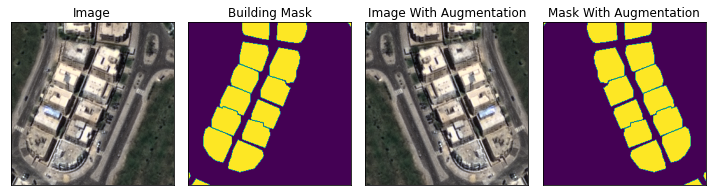

In [29]:
# Lets look at augmented data we have
dataset = Dataset(TRAIN_SPLIT_IMG_DIR, TRAIN_SPLIT_LABEL_DIR, classes=['building'])
dataset_aug = Dataset(TRAIN_SPLIT_IMG_DIR, TRAIN_SPLIT_LABEL_DIR, classes=['building'], augmentation=get_training_augmentation())

image, mask = dataset[5] # get some sample
image_aug, mask_aug = dataset_aug[5]

visualize(
    image=image, 
    building_mask=mask,
    image_with_augmentation=image_aug,
    mask_with_augmentation=mask_aug
)

## Segmentation model training
---

In [31]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [32]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['building']
LR = 0.0001
EPOCHS = 1

preprocess_input = sm.get_preprocessing(BACKBONE)

In [33]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [34]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [35]:
# Dataset for train images
train_dataset = Dataset(
    TRAIN_SPLIT_IMG_DIR, 
    TRAIN_SPLIT_LABEL_DIR, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    VAL_SPLIT_IMG_DIR, 
    VAL_SPLIT_LABEL_DIR, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
# assert train_dataloader[0][0].shape == (BATCH_SIZE, 1024, 1024, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, 1024, 1024, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./E3_2_best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [43]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [62]:
EPOCHS = 1
history_2 = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

3868/3868 [==============================] - 870s 225ms/step - loss: 0.4118 - iou_score: 0.5589 - f1-score: 0.6824 - val_loss: 0.5233 - val_iou_score: 0.6433 - val_f1-score: 0.7371


In [44]:
history.history.keys()

dict_keys(['loss', 'iou_score', 'f1-score', 'val_loss', 'val_iou_score', 'val_f1-score', 'lr'])

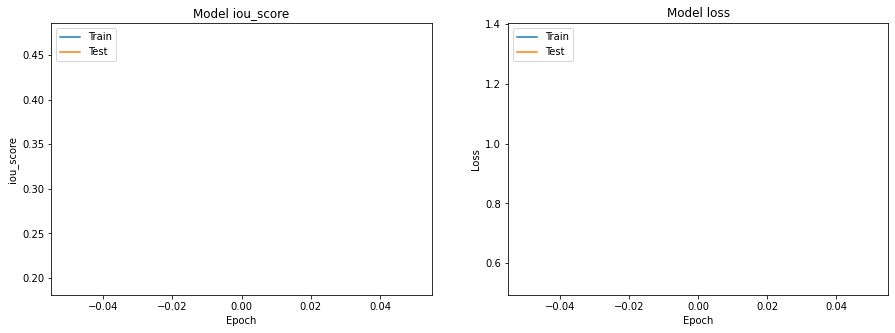

In [46]:
# Plot training & validation iou_score values
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model Evaluation
---

<!-- test set을 보존하지 않았기 때문에 하위 내용은 실행을 시킬 수 없었다. -->

## Visualization of results on test dataset¶
---

In [41]:
reconstructed_model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
reconstructed_model.compile(optim, total_loss, metrics)
reconstructed_model.load_weights('./E3_2_best_model.h5')

In [42]:
paths = [ f'{TRAIN_SPLIT_IMG_DIR}/{train_target_list[0]}_{i}.png' for i in range(5) ]
paths

['/home/aiffel-dj1/workspace/Hackerton/workspace/Model/split/train/image/BLD00001_PS3_K3A_NIA0276_0.png',
 '/home/aiffel-dj1/workspace/Hackerton/workspace/Model/split/train/image/BLD00001_PS3_K3A_NIA0276_1.png',
 '/home/aiffel-dj1/workspace/Hackerton/workspace/Model/split/train/image/BLD00001_PS3_K3A_NIA0276_2.png',
 '/home/aiffel-dj1/workspace/Hackerton/workspace/Model/split/train/image/BLD00001_PS3_K3A_NIA0276_3.png',
 '/home/aiffel-dj1/workspace/Hackerton/workspace/Model/split/train/image/BLD00001_PS3_K3A_NIA0276_4.png']

In [72]:
# inference 함수 정의
# todos
# 1. input img split
# 2. inference
# 3. merge image

In [44]:
STRIDE_SIZE = 192
INPUT_SIZE = 256
pts = get_slice_pos(25, STRIDE_SIZE, INPUT_SIZE)

In [ ]:
def inference(src_path, pts):
    sub_imgs = [np.expand_dims(img, axis=0) for img in split_png(src_path, pts)]
    pre_imgs = [model.predict(img).round() for img in sub_imgs]
    pre_imgs = [pre[..., 0].squeeze() for pre in pre_imgs]
    

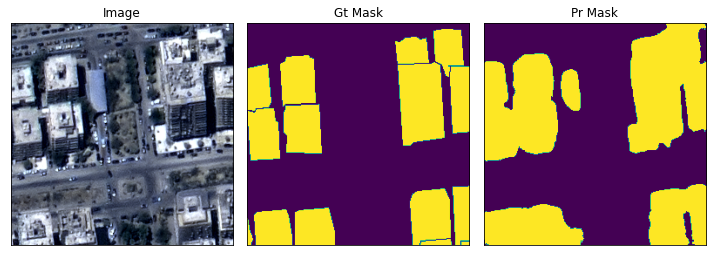

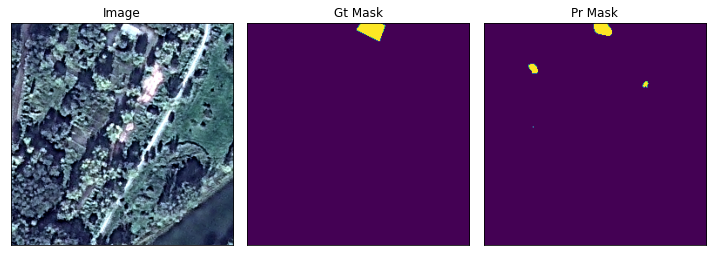

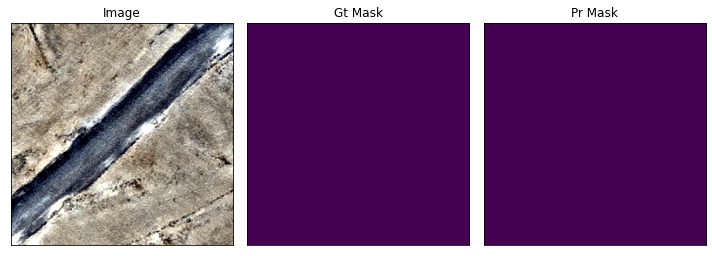

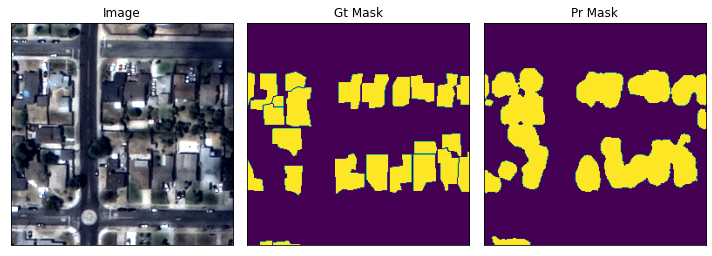

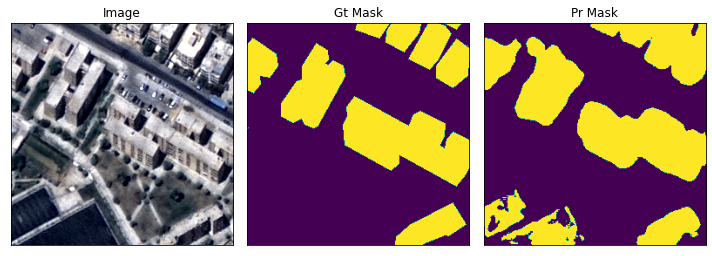

In [43]:
n = 5
ids = np.random.choice(np.arange(len(valid_dataset)), size=n)

for i in ids:
    image, gt_mask = valid_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = reconstructed_model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [ ]:
https://geoffboeing.com/2016/11/osmnx-python-street-networks/